# Julia Set
a) First I'll generate the Julia set.

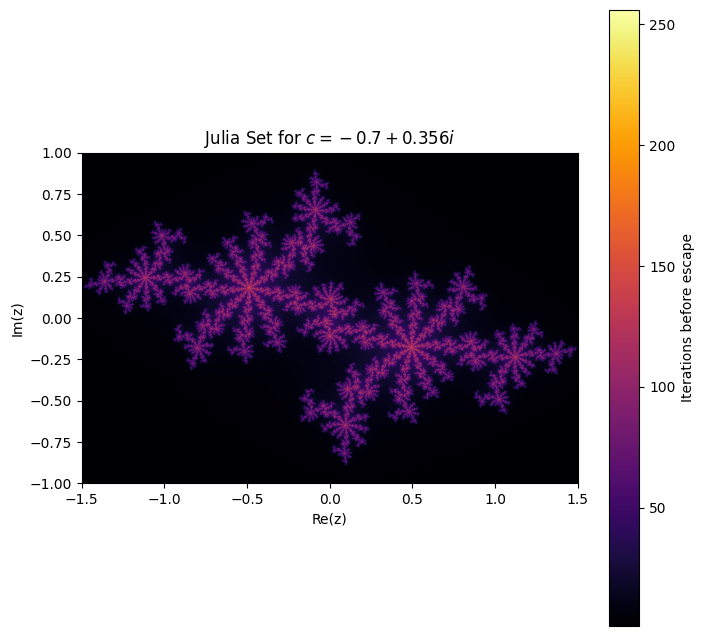

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
c = complex(-0.7, 0.356)  # Julia set constant
x_min, x_max = -1.5, 1.5
y_min, y_max = -1.0, 1.0
resolution = 800  # Points per unit length
max_iter = 256  # Number of iterations

# Define grid size
width = int((x_max - x_min) * resolution)  # Number of x points
height = int((y_max - y_min) * resolution)  # Number of y points

# Create a grid of complex numbers
x_values = np.linspace(x_min, x_max, width)
y_values = np.linspace(y_min, y_max, height)
X, Y = np.meshgrid(x_values, y_values)
Z = X + 1j * Y  # Convert to complex numbers

# Julia set computation
julia_set = np.zeros(Z.shape, dtype=int)
for i in range(max_iter):
    mask = np.abs(Z) < 2  # Only iterate points within the escape radius
    Z[mask] = Z[mask]**2 + c
    julia_set[mask] += 1  # Count iterations before escape

julia_fin = julia_set[julia_set==256]

# Plot the heatmap
plt.figure(figsize=(8, 8))
plt.imshow(julia_set, extent=[x_min, x_max, y_min, y_max], cmap='inferno', origin='lower')
plt.colorbar(label="Iterations before escape")
plt.xlabel("Re(z)")
plt.ylabel("Im(z)")
plt.title("Julia Set for $c = -0.7 + 0.356i$")
plt.show()


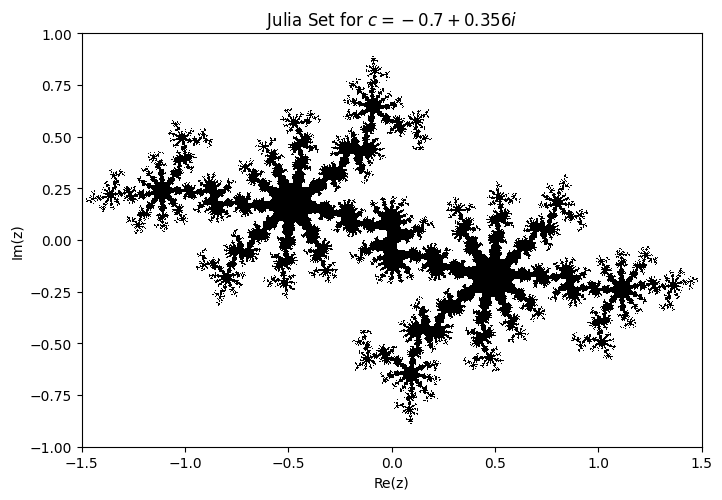

In [2]:
#Now selecting a certain number of points

julia_fin = (julia_set >40).astype(int)  # max_iter = 256

plt.figure(figsize=(8, 8))
plt.imshow(julia_fin, extent=[x_min, x_max, y_min, y_max], cmap="gray_r", origin="lower", interpolation='none')
plt.xlabel("Re(z)")
plt.ylabel("Im(z)")
plt.title("Julia Set for $c = -0.7 + 0.356i$")
plt.show()


b) I'll use the monotone chain method to generate a convex hull. Then I'll print it's area.

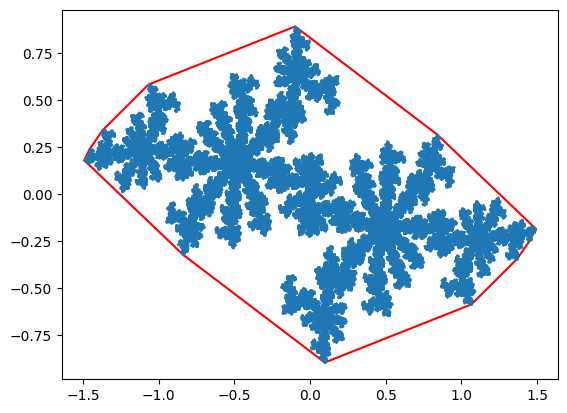

3.006401197497081  is the area of the convex hull


In [12]:
points = np.column_stack(np.where(julia_fin == 1))
# Convert pixel indices to real-world coordinates (e.g., scaling them back to the x, y range)
real_points = np.column_stack((x_values[points[:, 1]], y_values[points[:, 0]]))



def orientation(p, q, r):     #returns 1 if CW, 2 if CCW
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])      #p is current point, q is next, r is next next
    if val == 0:
        return 0
    return 2 if val > 0 else 1

def monotone_chain(points):
    # Sort points
    points = sorted(points, key=lambda p: (p[0], p[1]))
    
    # Build the lower hull
    lower = []
    for p in points:
        while len(lower) >= 2 and orientation(lower[-2], lower[-1], p) != 2:  # Remove non-convex points
            lower.pop()
        lower.append(p)
    
    # Build the upper hull
    upper = []
    for p in reversed(points):
        while len(upper) >= 2 and orientation(upper[-2], upper[-1], p) != 2:  # Remove non-convex points
            upper.pop()
        upper.append(p)
    
    # Combine lower and upper hull, excluding the last point of each (it's repeated)
    return lower[:-1] + upper[:-1]

# Compute the convex hull
hull = monotone_chain(real_points)

# Convert hull to a numpy array for easy plotting
hull = np.array(hull)

# Plot the convex hull
X_f = hull[:, 0]
Y_f = hull[:, 1]
plt.plot(np.append(X_f, X_f[0]), np.append(Y_f, Y_f[0]), 'r-')  # Close the loop
plt.plot(real_points[:, 0], real_points[:, 1], linestyle='', marker='.', markersize=1)
plt.show()


def convex_hull_area(points):
    """
    Compute the area of a convex hull using the Shoelace Theorem.
    """
    # Ensure the points are in a NumPy array
    points = np.array(points)
    
    # Extract x and y coordinates
    x = points[:, 0]
    y = points[:, 1]
    
    # Apply the Shoelace formula
    area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    
    return area


print(convex_hull_area(hull), ' is the area of the convex hull')

c) Compute the area of the interior. I can do this simply by summing up all points in the Julia set. Of course, this number isn't exact because I arbitrarily defined points being inside the set as not escaping after 50 iterations.

In [13]:


    
area_interior = np.sum(julia_fin)* (1/800)**2  # Count pixels with value 1

print("Approximate Julia Set Area:", area_interior)


Approximate Julia Set Area: 0.781153125


d) Box counting method

6 1.791759469228055
18 2.8903717578961645
54 3.988984046564274
168 5.123963979403259
550 6.309918278226516
1716 7.447751280047907
2470 7.8119734296220225
6926 8.843037724962366
8102 8.999866223762636
9538 9.16303909885817
11544 9.353921100453707
14128 9.555913922843741
17878 9.791326185647797
23536 10.066286442841218
31868 10.369357650500257
42928 10.667279572665405


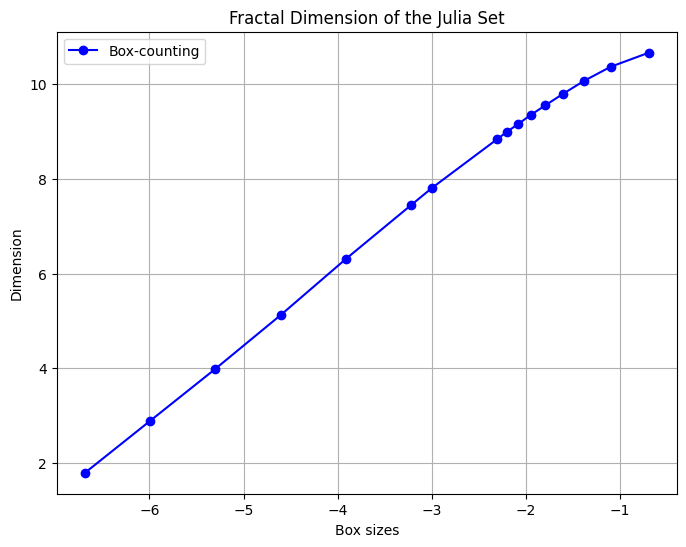

In [ ]:


# Box sizes to test
box_sizes = [800, 400, 200, 100, 50, 25, 20, 10,9,8,7,6, 5,4,3,2]

# Initialize a list to store the log values
Nlist = []
invblist = []

# Get the dimensions of the image
height, width = julia_fin.shape

# Loop over each box size
for bsize in box_sizes:
    # Calculate the number of boxes along each axis
    num_boxes_x = width // bsize
    num_boxes_y = height // bsize
    
    # Count how many boxes contain at least one point in the Julia set
    N = 0
    for i in range(num_boxes_x):
        for j in range(num_boxes_y):
            # Define the coordinates of the box
            x_start = i * bsize
            x_end = (i + 1) * bsize
            y_start = j * bsize
            y_end = (j + 1) * bsize
            
            sub_box = julia_fin[y_start:y_end, x_start:x_end]
            
            # Check if the box contains both 0s and 1s (i.e., it's an edge box)
            if np.any(sub_box == 0) and np.any(sub_box == 1):
                N += 1  # Count as an edge box
    
    # Calculate the log values
    #print(N, ', ', bsize)
    
    Nlist.append(np.log(N))
    print(N, np.log(N))

    invblist.append(np.log(1/bsize))
    


plt.figure(figsize=(8, 6))
plt.plot(invblist, Nlist, 'o-', color='blue', label="Box-counting")
plt.xlabel('Box sizes')
plt.ylabel('Number of overlaps')
plt.title("Fractal Dimension of the Julia Set")
plt.grid(True)
plt.legend()
plt.show()


The fractal dimension comes from estimating the slope of this line. So, I conclude the fractal dimension is about 5/3.